## Feature definition and creation of NPZ files containing the feature matrix, and the target vector for each set.

In [1]:
import numpy as np
import pandas as pd
import import_ipynb
from custom_features import get_all_features
from custom_features import get_pswm  

In [2]:
dataset = pd.read_csv("../Data_Preparation/train_bench.tsv", sep = "\t")

# 5-cross-validation run: for each run i, testing set=i, validation set=((i)%5)+1, training sets = remaining i sets


for i in range(1,6): #iteration on the sets 
    training_sets=((((i+1)%5)+1),(((i+2)%5)+1),(((i+3)%5)+1)) 
    testing = dataset.query(f"Set=='{i}'")
    validation = dataset.query(f"Set=='{((i)%5)+1}'")
    training = dataset.query(f"(Set=='{training_sets[0]}' or Set=='{training_sets[1]}' or Set=='{training_sets[2]}')")

    print("-"*100)
    print("testing set: ",i)
    print("validation set: ", ((i)%5)+1)
    print("training sets: ",training_sets)

    
    #TRAINING
    matrix_training = get_pswm(training , 13 , 2)
    feature_set_training , feature_order_training = get_all_features(training["Sequence"] , matrix_training, 15 )
    
    # create the target vector:
    vector_neg_pos = training["Class"]
    vector_proper = vector_neg_pos.map({"Positive": 1, "Negative": 0})
    target_training_vector = vector_proper.to_numpy()
    # Save the three feature matrices and the target vector to a .npz file with different keys
    np.savez(f'training_features_{i}.npz', matrix=feature_set_training, target=target_training_vector)

    #VALIDATION
    matrix_validation = get_pswm(validation , 13 , 2)
    feature_set_validation , feature_order_validation = get_all_features(validation["Sequence"] , matrix_validation, 15 )
 
    
    # create the target vector:
    vector_neg_pos = validation["Class"]
    vector_proper = vector_neg_pos.map({"Positive": 1, "Negative": 0})
    target_validation_vector = vector_proper.to_numpy()
    # Save the three feature matrices and the target vector to a .npz file with different keys
    np.savez(f'validation_features_{i}.npz', matrix=feature_set_validation, target=target_validation_vector)

    #TRAINING
    matrix_testing = get_pswm(testing , 13 , 2)
    feature_set_testing , feature_order_testing = get_all_features(testing["Sequence"] , matrix_testing, 15 )
    
    
    
    # create the target vector:
    vector_neg_pos = testing["Class"]
    vector_proper = vector_neg_pos.map({"Positive": 1, "Negative": 0})
    target_testing_vector = vector_proper.to_numpy()
    # Save the three feature matrices and the target vector to a .npz file with different keys
    np.savez(f'testing_features_{i}.npz', matrix=feature_set_testing, target=target_testing_vector)


    #now we have created a file for each set, for that iteration

----------------------------------------------------------------------------------------------------
testing set:  1
validation set:  2
training sets:  (3, 4, 5)
----------------------------------------------------------------------------------------------------
testing set:  2
validation set:  3
training sets:  (4, 5, 1)
----------------------------------------------------------------------------------------------------
testing set:  3
validation set:  4
training sets:  (5, 1, 2)
----------------------------------------------------------------------------------------------------
testing set:  4
validation set:  5
training sets:  (1, 2, 3)
----------------------------------------------------------------------------------------------------
testing set:  5
validation set:  1
training sets:  (2, 3, 4)


## Feature selection and SVM training

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef

In [4]:
#Load the npz files for each iteration
loaded_data_train = np.load('training_features_1.npz')
x_train = loaded_data_train['matrix']
y_train = loaded_data_train['target']

loaded_data_test = np.load('testing_features_1.npz')
x_test = loaded_data_test['matrix']
y_test = loaded_data_test['target']

loaded_data_validation = np.load('validation_features_1.npz')
x_validation = loaded_data_validation['matrix']
y_validation = loaded_data_validation['target']

In [5]:
best_mcc=-1

C_grid = [0.1, 1.0, 10.0, 100.0]
gamma_grid = ["scale", 0.01, 0.1, 1.0]

pipeline = Pipeline([("scaler" , StandardScaler()) , ("svm" , SVC())])


for C in C_grid:
    for gamma in gamma_grid:
        pipeline.set_params(svm__kernel="rbf",svm__C=C , svm__gamma=gamma)
        pipeline.fit(x_train, y_train)                 # fit on TRAIN
        y_pred = pipeline.predict(x_test)
        mcc = matthews_corrcoef(y_test, y_pred)      
        if mcc > best_mcc:
            best_mcc = mcc
            best_params_base = {"C": C, "gamma": gamma}


Top 10 features by Gini importance:
               feature  importance
0           VhonHeijne    0.336293
1      tm_tendency_max    0.082515
2    max_miyazawa_mean    0.048151
3   chou_fasman_h_mean    0.040907
4      flexibility_max    0.025222
5     flexibility_mean    0.023012
6             basicity    0.020965
7           punta_mean    0.020850
8                    R    0.020081
9     tm_tendency_mean    0.019669
10           punta_max    0.019153
11       miyazawa_mean    0.018958
12                   L    0.018236
13      bulkiness_mean    0.017160
14                   C    0.017142
15                   K    0.016514
16    chou_fasma_b_max    0.015744
17   chou_fasman_h_max    0.015173
18          argos_mean    0.015036
19                   E    0.014674
20   chou_fasma_b_mean    0.014202
21                   I    0.013950
22                   S    0.012156
23   aromatic_residues    0.012134
24       bulkiness_max    0.011935
25           argos_max    0.011102
26                 

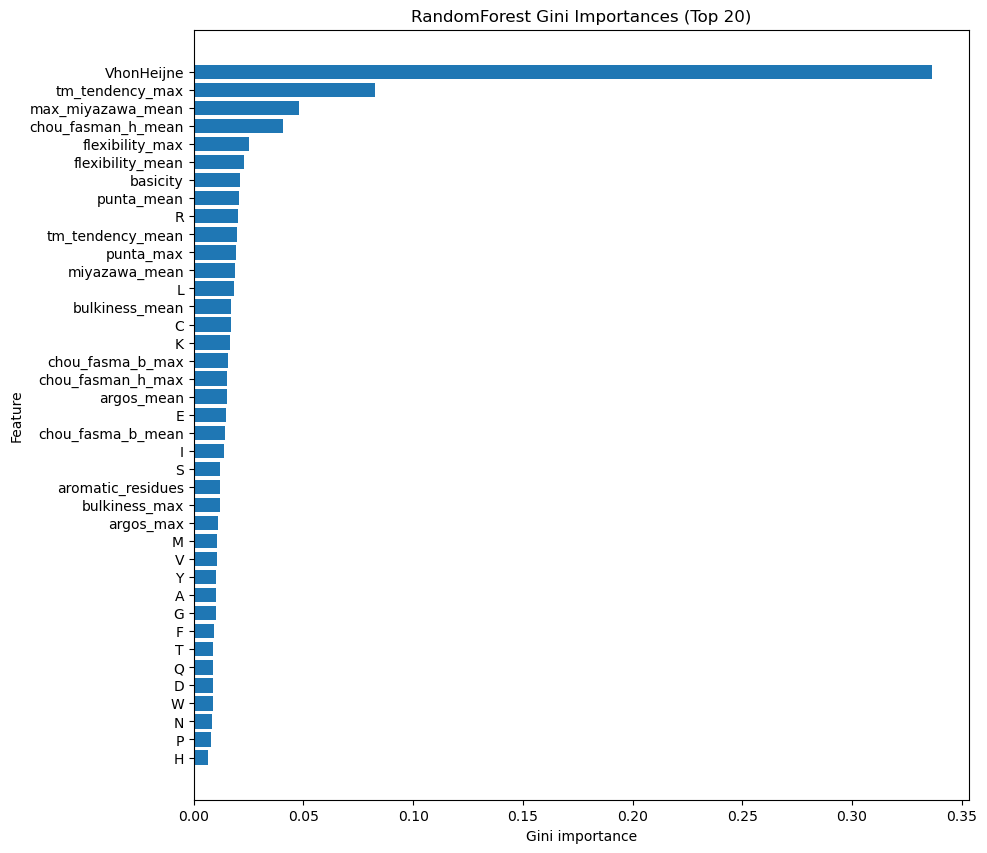

In [16]:
rf = RandomForestClassifier(
    n_estimators=400,
    n_jobs=-1
) 
#costruttore della random forest. n_jobs si riferisce al numero di operazioni .fit da parallelizzare (visto che gli alberi sono indipendenti)
# -1 vuol dire utilizzare tutti i processori in parallelo. 

rf.fit(x_train, y_train)  # fit only on TRAIN

gini_imp = pd.Series(rf.feature_importances_, index=feature_order_testing).sort_values(ascending=False)
# la funzione feature_importances_ calcola l'importanza delle features basandosi sull impurità

# da qui in poi è semplicemente plotting e cazzate varie. 
gini_df = gini_imp.reset_index()
gini_df.columns = ["feature", "importance"]
print("features by Gini importance:")
print(gini_df)

# Plot top 20
plt.figure(figsize=(10, 10))
plt.barh(gini_df["feature"][::-1], gini_df["importance"][::-1])
plt.xlabel("Gini importance")
plt.ylabel("Feature")
plt.title("RandomForest Gini Importances")
plt.show()